In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.stats import shapiro
from scipy import stats
from scipy.special import inv_boxcox

## granger test

In [2]:
#On crée la fonction pour tester les corr respectives pour modèle VAR
def grangers_test(data, lag, test='ssr_chi2test',verbose=False):    
    """Les valeurs dans le df sont les p-valeurs
    L'hypothèse H0 de notre test est la suivant :
        "Les prédictions de la série X n'influence pas les prédictions de la série Y"
    Ce qui signifie qu'une p-valeur inférieure à 0.05 rejette l'hypothèse H0 et incite à garder ce couple de valeurs
    Comme on s'intéresse à la prédiciton de la variable 1, on ne va jamais l'abandonner

Les arguments sont :
    Data, le DF de nos valeurs
    maxlag, le fameux maxlag pour le nombre de paramètres dans l'équation'
    variables : une list qui contient le nom des variables c'est à dire le nom de nos colonnes'
    """
    df = pd.DataFrame(np.zeros((len(data.columns), len(data.columns))), columns=data.columns, index=data.columns)
    for col in df.columns:
        for row in df.index:
            test_result = grangercausalitytests(data[[row, col]], maxlag=[lag], verbose=False)
            p_values = round(test_result[lag][0][test][1],4) #on va avoir toutes les p-valeurs une part lag
            p_value = np.min(p_values) #On s'intéresse à la valeur minimale des p-valeur
            df.loc[row, col] = p_value
    df.columns = [var for var in data.columns]
    df.index = [var + '_Y' for var in data.columns]
    return df

#Fonction test stationarité
def dickey_fuller_test(data, seuil_signif=0.05, name='', verbose=False):
    """On conduit un test de Dick-Fuller sur notre data set et on imprime les résultats"""
    """On rappelle que pour rejeter l'hypothèse H0 il faut que la p-value soit inférieur au seuil choisi, ici 0.05"""
    result = adfuller(data, autolag='BIC')
    output = {'statistique_du_test':round(result[0], 4), 'p_value':round(result[1], 4), 'n_lags':round(result[2], 4), 'n_obs':result[3]}
    p_value = output['p_value'] 

    # Print Summary
    print(f'    Test de Dick-Fuller augmenté sur : "{name}"', "\n   ", '~'*47)
    print(f' Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.')
    print(f' La p-value est de      : {p_value}')
    print(f' Niveau de confiance    = {seuil_signif}')
    print(f' Statistique de test    = {output["statistique_du_test"]}')
    print(f' Nombre de lags choisis = {output["n_lags"]}')

    if p_value <= seuil_signif:
        print(f" => P-Value = {p_value} <= {seuil_signif}. On rejette H0 au seuil de confiance.")
        print(f" => La série est STATIONNAIRE.")
    else:
        print(f" => P-Value = {p_value} > {seuil_signif}. On ne peut pas rejeter H0 au seuil de confiance.")
        print(f" => La série est NON stationnaire.")

## box cox test on features

In [3]:
def box_cox_test(dataframe_to_test):
    """We will test for each variable if a BoxCox transform brings us more normality

    Args:
        dataframe_to_test (dataframe): the dataframe that holds our data
    """
    list_non_transformed = []
    list_box_cox = []
    for col in dataframe_to_test:
        data = dataframe_to_test[col]
        if (data < 0).values.any():
            list_non_transformed.append(col)
            continue
        fig = plt.figure()
        ax1 = fig.add_subplot(221)
        prob = stats.probplot(data, dist=stats.norm, plot=ax1)
        ax1.set_xlabel('')
        ax1.set_title('Probplot against normal distribution')

        ax21 = fig.add_subplot(222)
        ax21.hist(data)
        ax21.set_xlabel(col)
        ax21.set_title('distplot')

        # normality test
        stat, p = stats.normaltest(data)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')

        xt, _ = stats.boxcox(data)
        if not np.isfinite(xt).any():
            list_non_transformed.append(col)
            continue
        list_box_cox.append(col)
        
        ax2 = fig.add_subplot(223)
        prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
        ax2.set_title('Probplot after Box-Cox transformation')
        ax22 = fig.add_subplot(224)
        ax22.hist(xt)
        ax22.set_xlabel(col)
        ax22.set_title('distplot')

        stat, p = stats.normaltest(xt)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')
        
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.2, wspace=0.4)
        plt.show()
    print('*'*50 +'\n' +'*'*50)
    print(f"Les données suivantes n'ont pas pu être scaled (négatives, infinites) : {list_non_transformed}. \n Voici leur plot non transformé")
    for col in list_non_transformed:
        data = dataframe_to_test[col]
        fig = plt.figure()
        ax1 = fig.add_subplot(211)
        prob = stats.probplot(data, dist=stats.norm, plot=ax1)
        ax1.set_xlabel('')
        ax1.set_title('Probplot against normal distribution')

        ax21 = fig.add_subplot(212)
        ax21.hist(data)
        ax21.set_xlabel(col)
        ax21.set_title('distplot')

    return list_box_cox, list_non_transformed

## reduction of dataset thanks to granger test

In [4]:
#function to reduce dim thanks to granger test
def reduce_dim_granger_test(df_to_reduce, lag_to_apply):
    """We reduce the dataset thanks to the granger test 
        We test that every variables in the dataframe are usefull to predict each other, and if not, we drop them
        After each iteration of "features optimization", we run again the model fit in order to verify that the best lag_order has not changed.
        If it as, we run the granger test optimization again
    Args:
        df_to_reduce (_type_): the data frame we want to reduce
        lag_to_apply (_type_): the current lag order of the model we use in that precise iteration 

    Returns:
        _type_: we return the dataframr that has been reduced
    """
    df_granger = grangers_test(df_to_reduce, lag = lag_to_apply)
    np.fill_diagonal(df_granger.values, 0)
    #plt.figure(figsize = (16,5))
    #sns.heatmap(df_granger, annot = True)
    #plt.show()
    while (df_granger.values>= 0.05).any():
        list_feature_non_granger_causal = []
        list_value_non_granger_causal = []
        for col in df_granger.columns:
            if (df_granger[col].values >= 0.05).any() and col != 'nd':
                list_feature_non_granger_causal.append(col)
                list_value_non_granger_causal.append(sum(df_granger[col].values))
        df_feature_to_pop = pd.DataFrame(list_value_non_granger_causal, index = list_feature_non_granger_causal, columns=['p-value'])  
        df_to_reduce = df_to_reduce.drop(df_feature_to_pop['p-value'].idxmax(), axis = 1)
        df_granger = grangers_test(df_to_reduce, lag = 5)
        np.fill_diagonal(df_granger.values, 0)
        #plt.figure(figsize = (16,5))
        #sns.heatmap(df_granger, annot = True)

    return df_to_reduce

## r2_ajusted

In [5]:
def r2_ajusted(r2, df):
    longueur = len(df.index)
    nb_col = len(df.columns)
    score_ajusted = 1-((1-r2)*(longueur-1) / (longueur - nb_col -1))
    return score_ajusted

## predict

In [6]:
def predict_results(model_fitted, training_set, exog_for_predicting):
    lag_order = model_fitted.k_ar
    input_data = training_set.values[-lag_order:]
    y_predicted = model_fitted.forecast(y = input_data, steps = len(exog_for_predicting), exog_future=exog_for_predicting)

    df_predicted = pd.DataFrame(y_predicted, index=exog_for_predicting.index, columns=training_set.columns)
    return df_predicted

## inverting the diff

In [7]:
#pour detransfo data :
def inv_diff(df_orig, df_forecast, second_diff = False):
    columns = df_orig.columns
    df_fc_inv = df_forecast.copy()
    n_jour_cible = len(df_forecast)
    for col in columns:
        """
        Attention ! lorsque l'on inverse une différenciation, un récupère la "dernière donnée" à laquelle on rajoute
        la somme cumulée des valeurs différenciées.
        Dans le cas d'un array prédit, le dernier point de donnée n'est PAS le "-1" du train_set, mais le "-1-nb_jour_pred"
        Dans notre cas on va donc retourner 120 jours en arrière
        Dans le cas d'une double diff, on soustrait d'abord l'avant dernière valeur à la dernière
        """
        if second_diff:
            df_fc_inv[str(col)+'_1d'] = (df_orig[col].iloc[-n_jour_cible-1]-df_orig[col].iloc[-n_jour_cible-2]) + df_fc_inv[str(col)].cumsum()
            df_fc_inv[str(col)] = df_orig[col].iloc[-n_jour_cible-1] + df_fc_inv[str(col)+"_1d"].cumsum()
        else:
            df_fc_inv[str(col)] = df_orig[col].iloc[-n_jour_cible-1] + df_fc_inv[str(col)].cumsum()
    return df_fc_inv

## convergence lag features

In [32]:
def convergence_lag_features(initial_transformed_dataframe, initial_dataframe,
                             exog, maxlag_to_converge, n_period, targeted_feature):
    """_summary_

    Args:
        initial_dataframe (pandas Dataframe): The initial dataframe you want to perform the convergence on. It is the dataframe you want the data
        to be trained on, so it must be transformed, differenciated if needed...
        exog (pandas dataframe): the exogeneous features you give to your model. Must be known for train and test ! Good example is holidays, 
        Fourier features...
        maxlag_to_converge (int): the maximum number of lags to include in your model. The code will test them all so the bigger the longer 
        the training time ! Be careful as it is exponential UwU
        n_period (int): number of time periods (days, hours...) you want to predict

    Returns:
    model (statsmodel model in that cas) : the fitted model 
    training_set (pandas dataframe) : the training set being granger tested
    training_set_exog (pandas dataframe) : the training set being granger tested
    test_set (pandas dataframe) : the test set being granger tested
    test_set_exog (pandas dataframe) : the training set exog
    df_diff (pandas dataframe) :  the test set exog 
    result_normality (float) : the results of the normality test on resisdual. If not normal, confidence intervals might
    be unreliable
    result_whiteness (flaot) : the result of the whiteness of residuals.
    """
    mae_training_loop = [] 
    MAPE_training_loop = [] 
    aic_training_loop = []
    r2_training_loop= []
    best_model = None 
    best_df_diff = None

    training_set_exog = exog[:-n_period]
    test_set_exog = exog[-n_period:]
    initial_testing_set = initial_dataframe[-n_period:]

    for i in range(45, maxlag_to_converge): 
        df_diff = initial_transformed_dataframe.copy()
        df_diff= reduce_dim_granger_test(df_diff, i)

        training_set=df_diff[:-n_period]
        testing_set = df_diff[-n_period:]

        model = VAR(endog = training_set, exog = training_set_exog)
        model = model.fit(i)

        predict = predict_results(model, training_set, test_set_exog)

        initial_testing_set_updated = initial_testing_set[predict.columns]
        initial_dataframe_uptaded = initial_dataframe[predict.columns]

        predict = inv_diff(initial_dataframe_uptaded, predict)

        sns.set(style="ticks", context="talk")
        plt.style.use("dark_background")
        fig, ax = plt.subplots(figsize=(15,10), dpi = 80)
        test_pred, = ax.plot(predict.index, predict['tsd'], color = "b")
        test_test, = ax.plot(predict.index, initial_testing_set_updated['tsd'], color = "g")
        ax.legend((test_pred, test_test), ("prediction", "réel"), loc = "upper left")
        fig.show()

        mae = mean_absolute_error(initial_testing_set_updated[targeted_feature], predict[targeted_feature])
        if len(mae_training_loop) == 0 or min(mae_training_loop) > mae:
            best_model = model
            best_df_diff = df_diff
        mae_training_loop.append(mae)
        MAPE_training_loop.append(mae / initial_testing_set_updated[targeted_feature].mean())
        r2_training_loop.append(r2_ajusted(r2_score(initial_testing_set_updated[targeted_feature], predict[targeted_feature]), predict))
        aic_training_loop.append(model.aic)
    
    training_metrics = pd.DataFrame()
    training_metrics['mae'] = mae_training_loop
    training_metrics['mape'] = MAPE_training_loop
    training_metrics['r2'] = r2_training_loop
    training_metrics['aic'] = aic_training_loop

    training_set=best_df_diff[:-n_period]
    testing_set = best_df_diff[-n_period:]
    initial_dataframe_uptaded = initial_dataframe[best_df_diff.columns]
    return best_model, training_set, training_set_exog, testing_set, test_set_exog, best_df_diff, training_metrics,initial_dataframe_uptaded

In [9]:
mae_training_loop = []

In [10]:
len(mae_training_loop) == 0

True

In [11]:
#Fonction plotting historique, True, Pred
def plot_pred_true(y_pred, y_true):
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(15,10), dpi = 80)
    test_pred, = ax.plot(date_du_split, y_pred, color = "b")
    test_test, = ax.plot(date_du_split, y_true, color = "g")
    ax.legend((test_pred, test_test), ("prediction", "réel"), loc = "upper left")
    fig.show()
    return plt.savefig("resultat.png")

def plot_pred_true_total(y_pred, y_true):
    date_list = df.index.tolist() + date_du_split.tolist()
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(15,10), dpi = 80)
    test_pred, = ax.plot(date_du_split, y_pred, color = "b")
    test_test, = ax.plot(date_totale, variable_cible, color = "g")
    ax.legend((test_pred, test_test), ("prediction", "réel"), loc = "upper left")
    fig.show()
    return plt.savefig("Historique et true VS prédiction.png")

# I. Data loading & quick prep

## a. Loading

In [12]:
df = pd.read_csv("C:/Users/vdistefano/Desktop/projet_dev_perso/Article_VAR_FR_Public/historic_demand_2009_2023_noNaN.csv")
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df = df.set_index('settlement_date')
df = df.drop(['settlement_period', 'period_hour'], axis = 1)
exog = df[['is_holiday']].copy()
df = df.drop(['is_holiday'], axis =1)

## b. Parameters

In [13]:
target_variable = "tsd"
index_df = df.index
n_period_predict = 48 * 7

## c. Prep/Cleaning

In [14]:
mask = (df.index > '2022-01-01')
df_pour_var = df.loc[mask]
exog_pour_var = exog.loc[mask]
df_pour_var = df_pour_var +1

In [15]:
initial_training_set=df_pour_var[:-n_period_predict]
initial_testing_set = df_pour_var[-n_period_predict:]

In [16]:
for name, column in df_pour_var.iteritems():
    dickey_fuller_test(column, name=column.name)
    print('\n')

    Test de Dick-Fuller augmenté sur : "nd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0322
 Niveau de confiance    = 0.05
 Statistique de test    = -3.0298
 Nombre de lags choisis = 45
 => P-Value = 0.0322 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "tsd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0063
 Niveau de confiance    = 0.05
 Statistique de test    = -3.5707
 Nombre de lags choisis = 45
 => P-Value = 0.0063 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "england_wales_demand" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est No

In [17]:
df_diff_1 = df_pour_var.diff().dropna()
exog_pour_var = exog_pour_var[1:]
for name, column in df_diff_1.iteritems():
    dickey_fuller_test(column, name=column.name)
    print('\n')

    Test de Dick-Fuller augmenté sur : "nd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0
 Niveau de confiance    = 0.05
 Statistique de test    = -27.2299
 Nombre de lags choisis = 45
 => P-Value = 0.0 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "tsd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0
 Niveau de confiance    = 0.05
 Statistique de test    = -32.6588
 Nombre de lags choisis = 45
 => P-Value = 0.0 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "england_wales_demand" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationn

Everything is now stationary ! We can go on :)

# III. Train, evualute and optimize

what if the BIC is minimized but the error is not ?

d:\soft\Anaconda\envs\uc_jouez_surclasse_2023\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vdistefano\AppData\Local\Temp\ipykernel_6096\1543043102.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
d:\soft\Anaconda\envs\uc_jouez_surclasse_2023\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vdistefano\AppData\Local\Temp\ipykernel_6096\1543043102.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


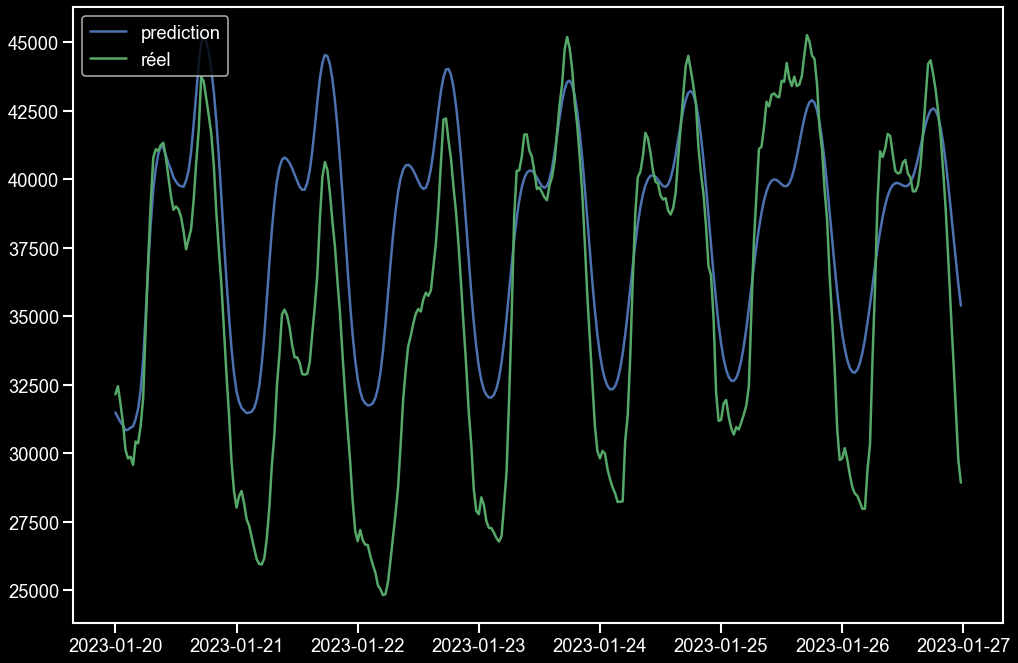

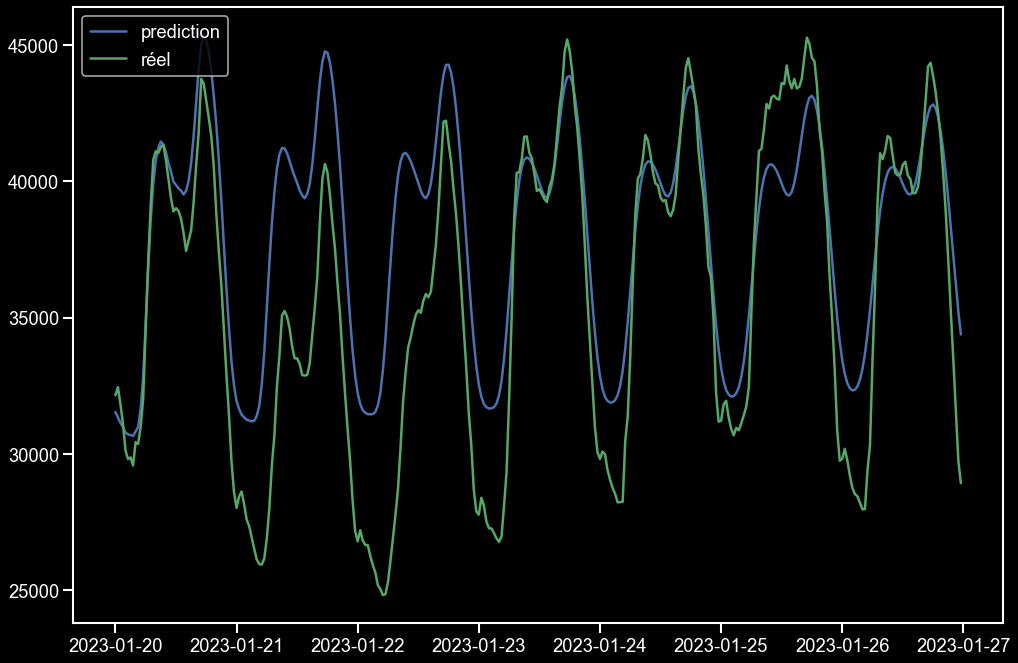

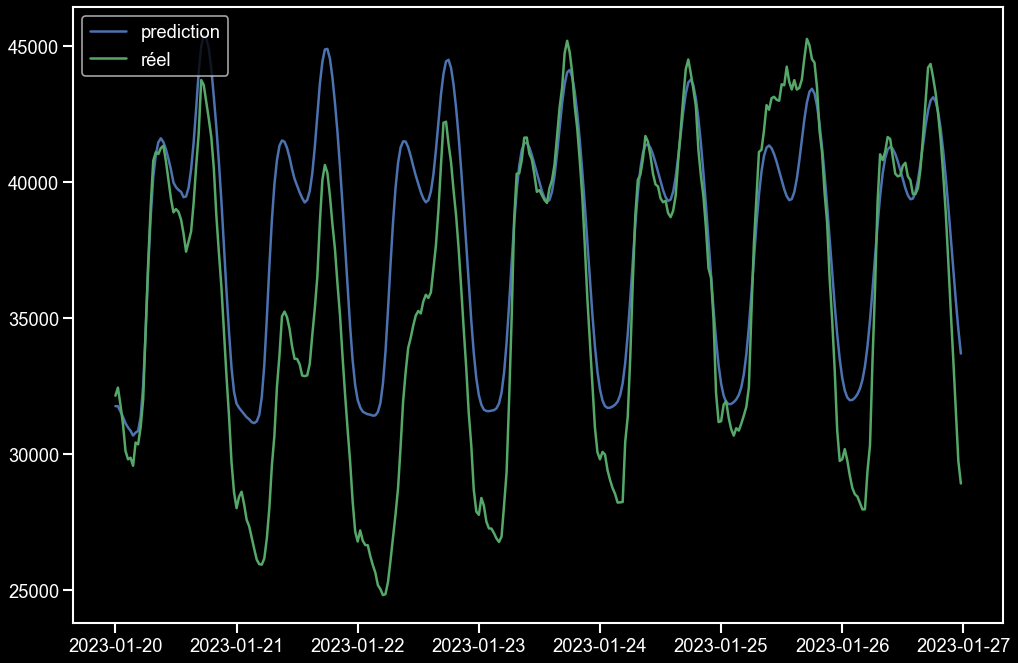

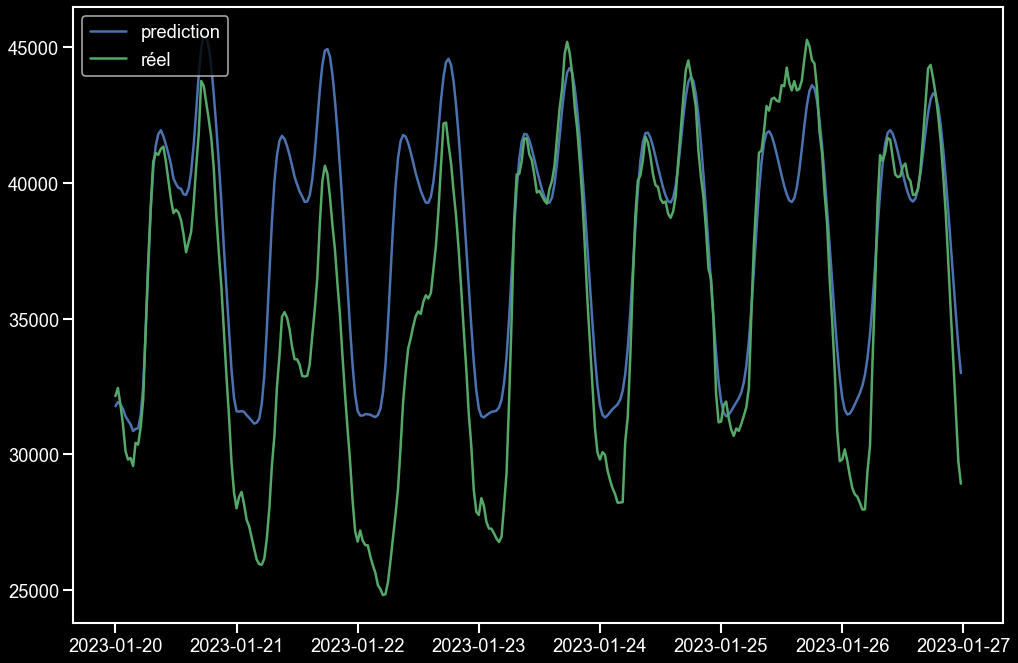

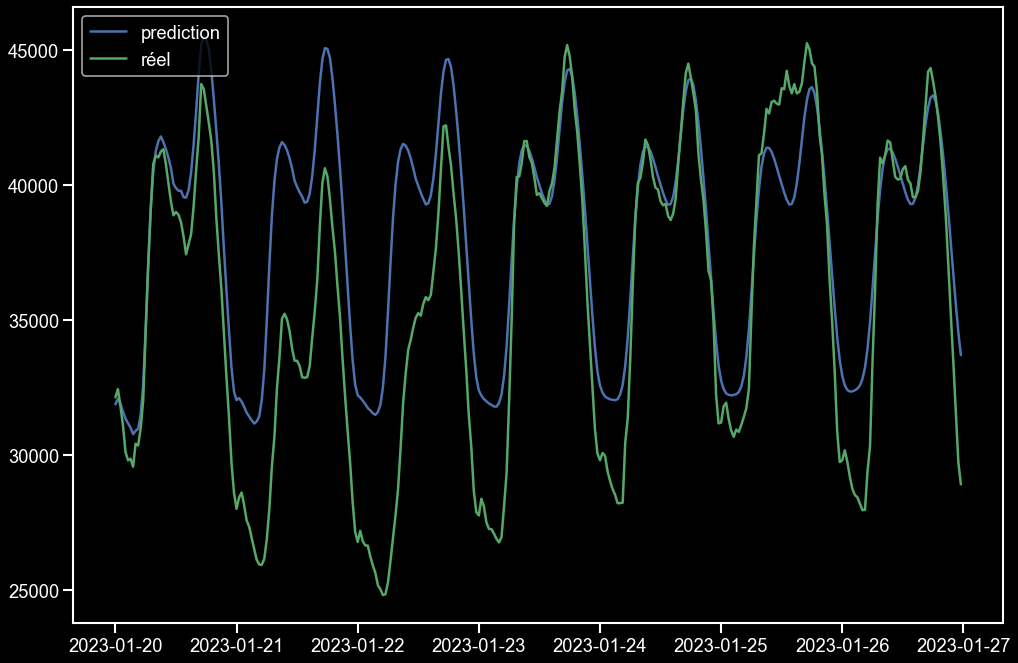

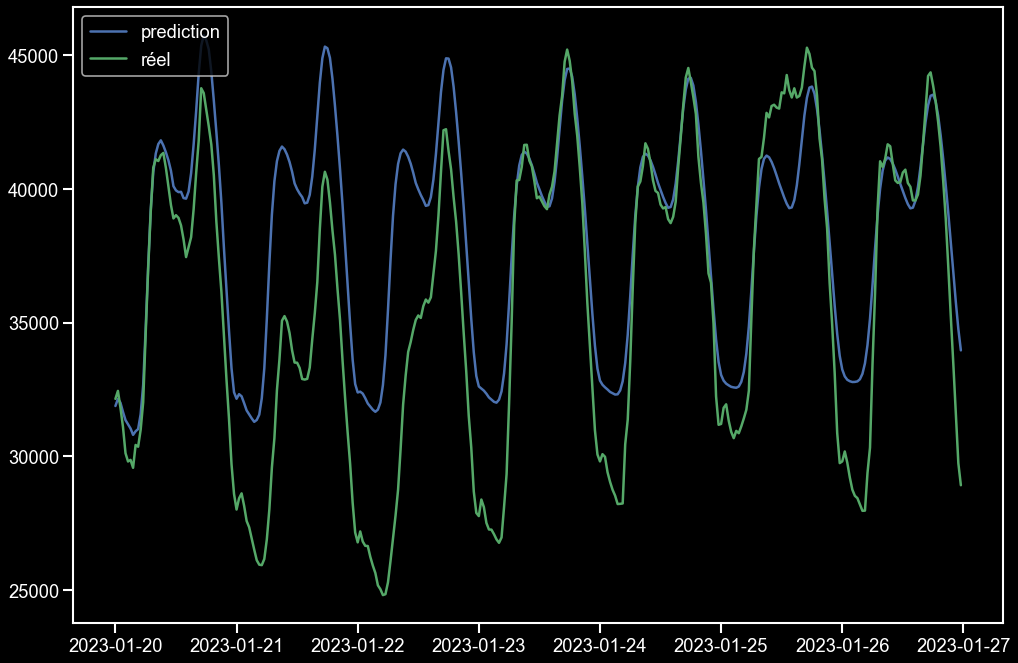

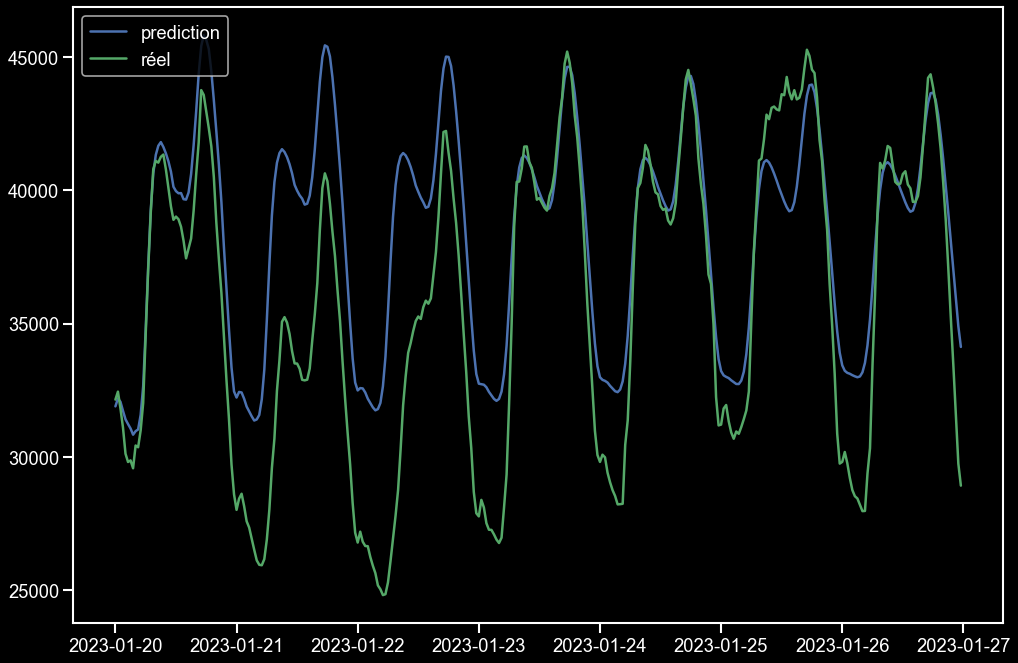

In [33]:
model_var, train_var, train_var_exog, test_var, test_var_exog, df_diff, df_optimizing_metrics, df_pour_var = convergence_lag_features(df_diff_1, df_pour_var,
                                                                                                                exog_pour_var, 52, n_period_predict, target_variable)

# IV. Predict on test

In [35]:
print(df_optimizing_metrics.describe())

               mae      mape        r2         aic
count     7.000000  7.000000  7.000000    7.000000
mean   2915.824804  0.081550  0.536160  104.941812
std     155.540439  0.004350  0.029093    0.188325
min    2728.801677  0.076319  0.493494  104.761825
25%    2815.950898  0.078757  0.516784  104.772277
50%    2930.748143  0.081967  0.541559  104.897827
75%    2956.700920  0.082693  0.553786  105.084249
max    3205.920174  0.089663  0.576928  105.219980


In [25]:
model_var = VAR(train_var, train_var_exog)

d:\soft\Anaconda\envs\uc_jouez_surclasse_2023\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [26]:
model_var = model_var.fit(6)

In [27]:
df_predicted = predict_results(model_var, train_var, test_var_exog)

In [28]:
df_predicted = inv_diff(df_pour_var, df_predicted)

In [29]:
df_predicted

,nd,tsd,england_wales_demand,embedded_wind_generation,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow
settlement_date,,,,,,,,,,,
2023-01-20 00:00:00,26034.142363,31380.932289,24028.018993,2030.400019,1249.332845,-803.733093,-709.562987,900.183994,-449.876803,-368.313668,-248.888421
2023-01-20 00:30:00,25259.264143,30700.672928,23333.020227,2019.180807,1314.877389,-816.029990,-697.555908,877.573285,-456.447803,-378.914622,-240.320851
2023-01-20 01:00:00,24428.219204,30089.928795,22599.663496,2004.095475,1396.657941,-847.581841,-700.505871,763.872833,-451.379986,-373.136011,-293.594476
2023-01-20 01:30:00,23959.095583,29673.761818,22163.183788,1985.048735,1423.416657,-866.984139,-711.338392,752.457780,-451.529900,-372.567623,-300.156177
2023-01-20 02:00:00,23604.434548,29484.815780,21855.991904,1959.158663,1366.223844,-924.386948,-818.331985,640.188467,-424.022126,-350.891931,-441.481634
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26 21:30:00,23995.037678,29750.632114,22202.983130,1737.087859,1350.597363,-954.456016,-831.400808,670.674502,-402.487841,-325.292545,-445.596061
2023-01-26 22:00:00,23994.777086,29750.283623,22202.751067,1736.961740,1350.630831,-954.603465,-831.494923,670.898701,-402.526058,-325.333318,-445.422639
2023-01-26 22:30:00,23994.516495,29749.935133,22202.519005,1736.835621,1350.664298,-954.750914,-831.589039,671.122900,-402.564275,-325.374091,-445.249218


C:\Users\vdistefano\AppData\Local\Temp\ipykernel_6096\1031854975.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


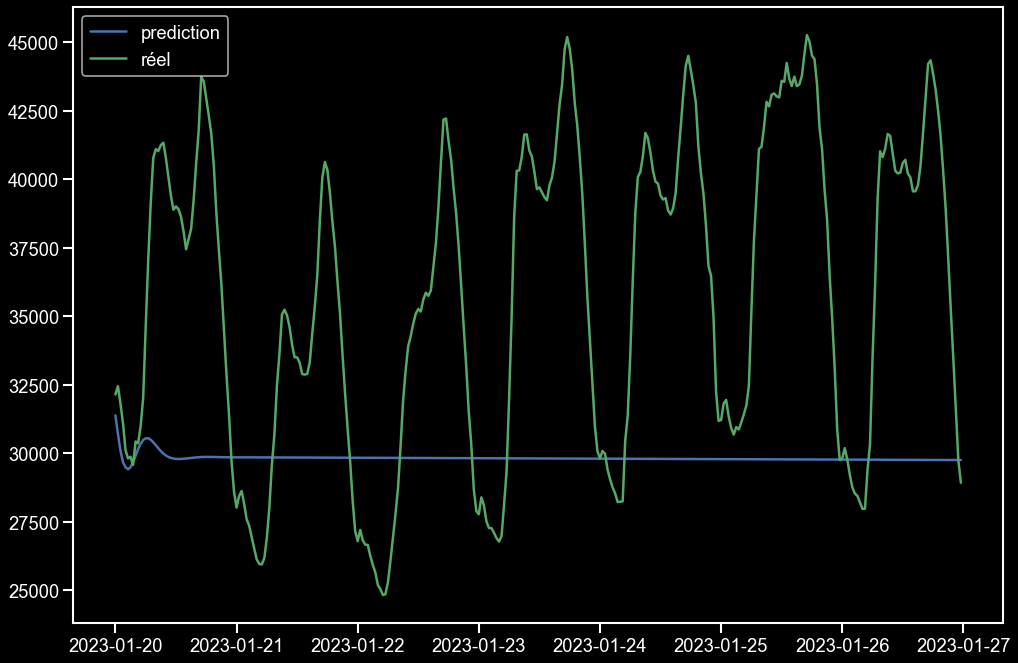

In [23]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(15,10), dpi = 80)
test_pred, = ax.plot(df_predicted.index, df_predicted['tsd'], color = "b")
test_test, = ax.plot(df_predicted.index, initial_testing_set['tsd'], color = "g")
ax.legend((test_pred, test_test), ("prediction", "réel"), loc = "upper left")
fig.show()

test model à la main

lag_order = model_var.k_ar
input_data = train_var.values[-lag_order:]
y_predicted = model_var.forecast(y = input_data, steps = len(test_var))

df_predicted = pd.DataFrame(y_predicted, index=test_var.index, columns=train_var.columns)

# V. De-transformation

df_true_results = inv_diff(df_pour_var, df_predicted, n_period_predict)

MAE_var = mean_absolute_error(df_pour_var[variable_cible.name].iloc[-n_period_predict:], df_true_results[variable_cible.name+'_forecast'])